# Handwritten Digit Recognition with Softmax Function on TensorFlow

We'll be using a subset of the MNIST dataset, that is, 1000 28x28-pixel images of handwritten digits (100 images of the digit 0, 100 images of the digit 1, and so on up to the digit 9). We'll use a fairly simple model of a Feedforward Neural Network, implementing the Softmax activation function on the units of the output layer and ReLU on the hidden layer(s).

In this notebook, we will specifically utilize TensorFlow library to help building, compiling, and fitting the model into the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
np.set_printoptions(precision=2)

In [2]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
X_train = np.loadtxt('train_X.csv', delimiter = ',')
Y_train = np.loadtxt('train_label.csv', delimiter = ',')

X_test = np.loadtxt('test_X.csv', delimiter = ',')
Y_test = np.loadtxt('test_label.csv', delimiter = ',')

The shape of the feature and target matrices best remain in (m, n).

In [4]:
print("shape of X_train :", X_train.shape)
print("shape of Y_train :", Y_train.shape)
print("shape of X_test :", X_test.shape)
print("shape of Y_test :", Y_test.shape)

shape of X_train : (1000, 784)
shape of Y_train : (1000, 10)
shape of X_test : (350, 784)
shape of Y_test : (350, 10)


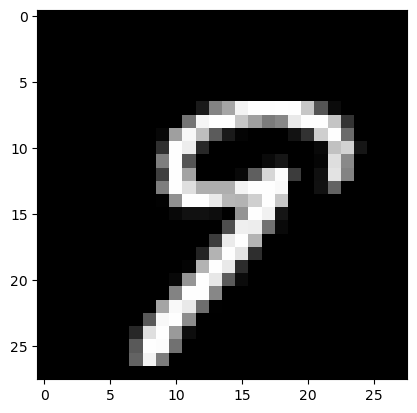

In [5]:
index = random.randrange(0, X_train.shape[0]) # Anywhere between 0 and the shape of first row (1000)
plt.imshow(X_train[index].reshape(28, 28), cmap='gray')
plt.show()

# Creating the Model

We use the Keras Dense layer to construct the FFNN architecture of two layers. Note the activation function used in each layer.

In [6]:
tf.random.set_seed(1234)  # applied to achieve consistent results
                          # we’ll get the same initial weights every time the code is run, 
                          # leading to the same model behavior and performance2.
model = Sequential(
    [
        tf.keras.Input(shape=(784,)),
        Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(0.01),   name = "L1"),
        Dropout(0.08),
        Dense(10, activation = 'linear', name = "L2")
    ], name = "mnist-softmax"
)

In [7]:
model.summary()

# Hidden layer (L1) : 784 * 112 individual weights + 112 biases (1 per unit) = 87920
# Output layer (L2) : 112 * 10 individual weights + 10 biases (1 per unit) = 1130

Model: "mnist-softmax"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 64)                50240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 L2 (Dense)                  (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


Below is how the weights and biases look like before fitting.

In [8]:
# Keep in mind that W1 is the matrix of all weights in layer 1 (784, 32)
# And that W2 is the matrix of all weights in layer 2 (32, 10)

W1, b1 = model.get_layer("L1").get_weights()
W2, b2 = model.get_layer("L2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(784, 64):
 [[-0.02  0.02  0.02 ...  0.01 -0.05  0.02]
 [-0.01  0.    0.06 ... -0.07  0.06 -0.01]
 [ 0.04 -0.05 -0.05 ...  0.02  0.08  0.02]
 ...
 [-0.08 -0.07 -0.08 ... -0.01  0.05 -0.04]
 [-0.02  0.01  0.06 ... -0.04  0.08  0.03]
 [ 0.   -0.    0.06 ...  0.01  0.02  0.07]] 
b1(64,): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
W2(64, 10):
 [[-0.16 -0.02 -0.27  0.16 -0.18  0.21  0.14 -0.1   0.21 -0.13]
 [-0.1   0.07 -0.28  0.14 -0.   -0.08  0.09 -0.08  0.22 -0.16]
 [-0.1   0.16  0.13 -0.21  0.21  0.13 -0.19  0.22  0.06 -0.08]
 [ 0.13  0.2   0.22 -0.09 -0.22 -0.04  0.23 -0.04  0.22  0.21]
 [-0.24 -0.    0.08 -0.27  0.04  0.16 -0.05 -0.06 -0.12  0.16]
 [-0.01 -0.24 -0.12  0.27  0.15 -0.13 -0.22 -0.09  0.12  0.01]
 [-0.1   0.09  0.03 -0.24 -0.1   0.26  0.22  0.27 -0.12  0.02]
 [ 0.02 -0.    0.13 -0.18  0.12  0.09 -0.21  0.12 -0.27  0.05]

Intuitively, we can map the value of each weight array of 784 elements in W1 as a 28x28 pixel image, similar to the shape of each training example.

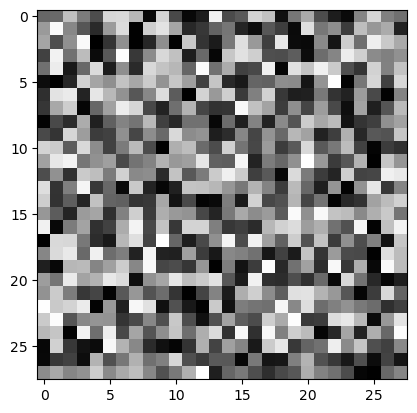

In [9]:
w1_image = W1[:, 0].reshape(28, 28)
plt.imshow(w1_image, cmap='gray')
plt.show()

As expected, it's just a jumble of ... whatever that might be, since no fitting has yet to be done on the dataset.

# Training and Fitting the Model

The statements below compile and train the network. Setting `from_logits=True` as an argument to the loss function specifies that the output activation was linear rather than a softmax.

In [10]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [11]:
model.fit(
    X_train, Y_train,
    epochs = 200
)

Epoch 1/200
32/32 [==============================] - 1s 6ms/step - loss: 45.9924 - accuracy: 0.3910
Epoch 2/200
32/32 [==============================] - 0s 3ms/step - loss: 7.7854 - accuracy: 0.6410
Epoch 3/200
32/32 [==============================] - 0s 3ms/step - loss: 3.5146 - accuracy: 0.7060
Epoch 4/200
32/32 [==============================] - 0s 3ms/step - loss: 2.4444 - accuracy: 0.7520
Epoch 5/200
32/32 [==============================] - 0s 3ms/step - loss: 2.1491 - accuracy: 0.7650
Epoch 6/200
32/32 [==============================] - 0s 3ms/step - loss: 1.7472 - accuracy: 0.7820
Epoch 7/200
32/32 [==============================] - 0s 3ms/step - loss: 1.4981 - accuracy: 0.7850
Epoch 8/200
32/32 [==============================] - 0s 6ms/step - loss: 1.4320 - accuracy: 0.8150
Epoch 9/200
32/32 [==============================] - 0s 3ms/step - loss: 1.2393 - accuracy: 0.8500
Epoch 10/200
32/32 [==============================] - 0s 3ms/step - loss: 1.2393 - accuracy: 0.8610
Epoch 11

After fitting the model into the respective inputs and targets of the dataset, we can see how the weights and biases turned out to be.

In [12]:
W1, b1 = model.get_layer("L1").get_weights()
W2, b2 = model.get_layer("L2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\nb1{b1.shape}:", b1)
print(f"W2{W2.shape}:\n", W2, f"\nb2{b2.shape}:", b2)

W1(784, 64):
 [[-4.23e-34 -1.63e-34  5.81e-35 ...  1.19e-34 -3.04e-34 -5.92e-34]
 [-3.78e-34  5.69e-35  4.19e-34 ... -1.21e-34  5.10e-35  5.75e-34]
 [ 3.75e-34 -2.79e-34 -5.66e-34 ...  7.46e-35 -1.01e-34 -3.89e-34]
 ...
 [ 4.79e-34 -4.70e-34  1.03e-34 ... -5.03e-34 -3.09e-34 -5.54e-34]
 [ 2.39e-34 -5.11e-34  5.13e-34 ...  4.06e-34  5.88e-34 -4.27e-34]
 [-5.06e-34  3.31e-15  1.57e-34 ...  4.72e-34 -1.15e-34  2.81e-36]] 
b1(64,): [-0.03 -0.06 -0.03 -0.05 -0.02 -0.03 -0.01 -0.03  0.02 -0.07  0.   -0.03
 -0.01 -0.05 -0.04 -0.03 -0.03 -0.05 -0.04 -0.04 -0.06 -0.03 -0.05 -0.03
 -0.03 -0.02 -0.02 -0.04 -0.01 -0.12 -0.05 -0.06 -0.02 -0.03 -0.02 -0.04
 -0.02 -0.03 -0.02 -0.03 -0.03 -0.03 -0.05 -0.02 -0.03 -0.03 -0.1  -0.05
  0.02 -0.05 -0.02 -0.06 -0.04  0.   -0.   -0.06 -0.03 -0.04 -0.03 -0.04
 -0.04 -0.02  0.01 -0.03]
W2(64, 10):
 [[-0.12 -0.05 -0.19  0.17 -0.21  0.19  0.07 -0.1   0.19 -0.09]
 [-0.09  0.14 -0.19  0.16 -0.02 -0.07  0.02 -0.12  0.14 -0.14]
 [-0.09  0.19  0.08 -0.19  0.19  0.03 

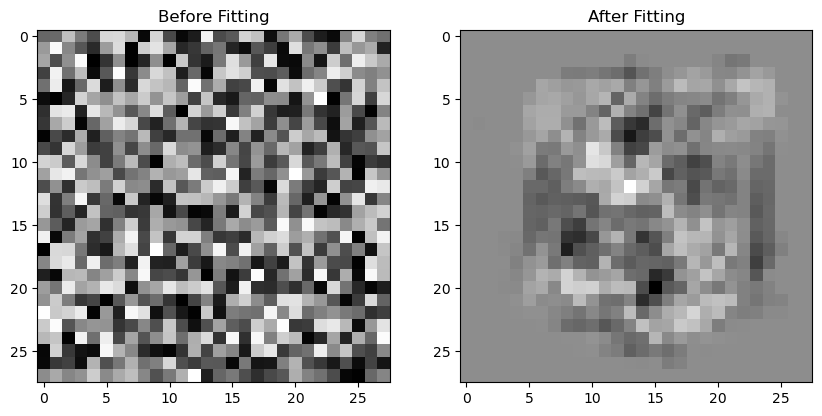

In [13]:
w1_image_fit = W1[:, 0].reshape(28, 28)
plt.figure(figsize=(10, 5))  # Set the figure size

plt.subplot(1, 2, 1)  # 1 row, 2 columns, index 1
plt.imshow(w1_image, cmap='gray')
plt.title('Before Fitting')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, index 2
plt.imshow(w1_image_fit, cmap='gray')
plt.title('After Fitting')

plt.show()

We can then predict on the X_test dataset. we first need to apply the Softmax activation function since the output layer uses a linear function. and thus does not represent the probability of each class.

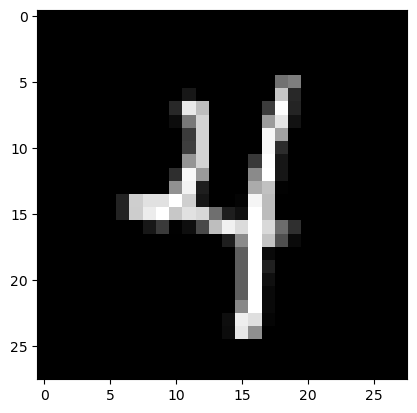

1/1 [==============================] - 0s 189ms/step
 Model probabilities: [[2.60e-18 0.00e+00 0.00e+00 2.31e-39 1.00e+00 1.22e-25 7.59e-25 6.85e-23
  0.00e+00 5.11e-19]]
 Model prediction: 4
 Actual target value: 4


In [14]:
idx = int(random.randrange(0,X_test.shape[0]))
plt.imshow(X_test[idx].reshape(28,28), cmap='gray')
plt.show()

label = np.argmax(Y_test[idx])


# Apply Softmax function
logits = model.predict(X_test[idx].reshape(1,784)) # TensorFlow only recognizes the shape of a tensor
# probabilities = np.exp(logits) / np.sum(np.exp(logits))

# We need to prevent numerical instability by ensuring that each logit has the value of 0 or negative
max_logit = np.max(logits)
shifted_logits = logits - max_logit
probabilities = np.exp(shifted_logits) / np.sum(np.exp(shifted_logits))

prediction = np.argmax(probabilities[0])

print(f" Model probabilities: {probabilities}")
print(f" Model prediction: {prediction}")
print(f" Actual target value: {label}")

We then compute the model's accuracy on the training set and the test set. We want the accuracy of the model to be the same between datasets, if not, it's a great indication of apparent data overfitting or underfitting.

In [15]:
# Evaluate on training set
train_loss, train_acc = model.evaluate(X_train, Y_train)
print('\nTraining accuracy:', train_acc)
print('Training loss:', train_loss)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('\nTest accuracy:', test_acc)
print('Test loss:', test_loss)


32/32 [==============================] - 0s 2ms/step - loss: 0.2590 - accuracy: 0.9910

Training accuracy: 0.9909999966621399
Training loss: 0.2589782476425171
11/11 [==============================] - 0s 2ms/step - loss: 2.1064 - accuracy: 0.8714

Test accuracy: 0.8714285492897034
Test loss: 2.1063807010650635
